In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from __future__ import print_function
from __future__ import absolute_import
#from tf.keras.utils.utils.layer_utils import convert_all_kernels_in_model
from keras.layers import Input
from keras.optimizers import Adam
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
from keras.preprocessing import image
from imgaug import augmenters as iaa
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.engine.topology import get_source_inputs
from keras.layers import GlobalMaxPooling1D, Dense, Conv1D,Conv2D
from keras import regularizers,optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (merge, Lambda)
from keras.layers.convolutional import (Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D)
import matplotlib.pyplot as plt
import random as random
import warnings,gc,csv,keras,os,sys
import imgaug as ia
import pandas as pd
import numpy as np
from keras.models import Model
from keras.regularizers import l2
import keras.backend as K

In [ ]:
%cd /content/drive/MyDrive/MRNET

In [ ]:
!wget http://download.cs.stanford.edu/deep/MRNet-v1.0.zip

In [ ]:
%cd /content/drive/MyDrive/MRNET/
!unzip MRNet-v1.0.zip

In [ ]:
def augment(image):
  aug=[]
  for s in range(len(image)):
      aug.append(ia.imresize_single_image(image[s], (227, 227)))
  aug=np.array(aug)
  return aug

def clear():
  aug= None
  gc.collect()

# To add the third channel(to color the image).
def add_rgb(grey_img):
  rgb_img = np.repeat(grey_img[..., np.newaxis], 3, -1)
  return rgb_img

# Load data, to skip metadata file.
def load_data(path):
  data = []
  for d in sorted(os.listdir(path)):
    if d!='.DS_Store':
      data.append(d)
      print("in iterator ", d)
      clear()
  return data

# Load labels from CSV files.  
def load_labels(path):
  labels = []
  read = pd.read_csv(path, names=['num', 'hot'])
  labels = list(read['hot'])
  return labels

def plot_graphs(y):
  plt.plot( epochs,y.history['accuracy'],'r')
  plt.xlabel("Epochs")
  plt.ylabel("accuracy")
  plt.title("Accuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_accuracy'],'b')
  plt.xlabel("Epochs")
  plt.ylabel("val_accuracy")
  plt.title("Vlidation Acuuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['loss'],'g')
  plt.xlabel("Epochs")
  plt.ylabel("loss")
  plt.title("Loss vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_loss'],'k')
  plt.xlabel("Epochs")
  plt.ylabel("val_loss")
  plt.title("Validation Loss vs Epochs")
  plt.show()

#Hyperparameters 
def Average(lst): 
    return sum(lst) / len(lst) 

# Loop over dataset for 300 times.
epoch=10
epochs=[0]*epoch
for i in range(0,epoch):
  epochs[i]=i

In [ ]:
#Load Data
train_axial_dir='/content/drive/MyDrive/MRNET/MRNet-v1.0/train/axial'
train_coronal_dir= '/content/drive/MyDrive/MRNET/MRNet-v1.0/train/coronal'
train_sagittal_dir= '/content/drive/MyDrive/MRNET/MRNet-v1.0/train/sagittal'

train_abnormal_labels= '/content/drive/MyDrive/MRNET/MRNet-v1.0/train-abnormal.csv'
train_acl_labels= '/content/drive/MyDrive/MRNET/MRNet-v1.0/train-acl.csv'
train_meniscus_labels= '/content/drive/MyDrive/MRNET/MRNet-v1.0/train-meniscus.csv'

In [ ]:
print("##############     Load Axial Data   ##############")
train_axial_data = os.listdir(train_axial_dir)

print("##############     Load Cronal Data   ##############")
train_coronal_data = os.listdir(train_coronal_dir)

print("##############     Load Sagital Data   ##############")
train_sagittal_data = os.listdir(train_sagittal_dir)

print("##############  Load Abnormal Labels   ##############")
train_abnormal_labels = load_labels(train_abnormal_labels)

print("##############  Load ACL Labels   ##############")
train_acl_labels = load_labels(train_acl_labels)

print("##############  Load Meniscus Labels   ##############")
train_meniscus_labels = load_labels(train_meniscus_labels)

##############     Load Axial Data   ##############
##############     Load Cronal Data   ##############
##############     Load Sagital Data   ##############
##############  Load Abnormal Labels   ##############
##############  Load ACL Labels   ##############
##############  Load Meniscus Labels   ##############


In [ ]:
val_axial_dir = '/content/drive/MyDrive/MRNET/MRNet-v1.0/valid/axial'
val_coronal_dir = '/content/drive/MyDrive/MRNET/MRNet-v1.0/valid/coronal'
val_sagittal_dir = '/content/drive/MyDrive/MRNET/MRNet-v1.0/valid/sagittal'

val_abnormal_labels= '/content/drive/MyDrive/MRNET/MRNet-v1.0/valid-abnormal.csv'
val_acl_labels= '/content/drive/MyDrive/MRNET/MRNet-v1.0/valid-acl.csv'
val_meniscus_labels= '/content/drive/MyDrive/MRNET/MRNet-v1.0/valid-meniscus.csv'

val_axial_data = os.listdir(val_axial_dir)
val_coronal_data = os.listdir(val_coronal_dir)
val_sagittal_data =  os.listdir(val_sagittal_dir)


val_abnormal_labels= load_labels(val_abnormal_labels)
val_meniscus_labels= load_labels(val_meniscus_labels)
val_acl_labels= load_labels(val_acl_labels)

In [ ]:
#MRNet - Model
ALEXNet = Sequential()

# 1st Convolutional Layer
ALEXNet.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
ALEXNet.add(Activation('relu'))

# Max Pooling
ALEXNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
ALEXNet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
ALEXNet.add(Activation('relu'))

# Max Pooling
ALEXNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
ALEXNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
ALEXNet.add(Activation('relu'))

# 4th Convolutional Layer
ALEXNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
ALEXNet.add(Activation('relu'))

# 5th Convolutional Layer
ALEXNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
ALEXNet.add(Activation('relu'))

# To build avg_pooling cnn layers.
average_pool = Sequential()
average_pool.add(layers.AveragePooling2D())
average_pool.add(layers.Flatten())
# To use alex net as feature extractor.
#average_pool.add(layers.Dense(1, activation='sigmoid'))

# Bild MRNET.
MRNet = Sequential([
    ALEXNet, 
    average_pool])

# Maxpooling
MRNet.add(Dense(256, activation ='relu',kernel_constraint=keras.constraints.MaxNorm(max_value=2, axis=0)))
MRNet.add(Dense(1, activation ='sigmoid'))
# stochastic gradient descent
sgd = optimizers.SGD(learning_rate=1e-4, decay=1e-6, momentum=0.9, nesterov=True)

ALEXNet.summary()
average_pool.summary()
MRNet.summary()

MRNet.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 23, 23, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         8

In [ ]:
# Training Data length
axialt_length = len(train_axial_data)
coronalt_length = len(train_coronal_data)
saggitalt_length= len(train_sagittal_data)

# Validiation Data length
axialv_length = len(val_axial_data)
coronalv_length = len(val_coronal_data)
saggitalv_length = len(val_sagittal_data)

# Data Generation and Shuffle Method.
def data_gen(data,label,path,data_length):
  all_data = list(zip(data,label))
  random.shuffle(all_data)
  i = 0
  while(True):
    if(i == data_length):
      yield(None,None)
      break
    for pair in all_data:
      if(pair[0] != '.DS_Store'):
        img = np.load(os.path.join(path,pair[0]),allow_pickle=True)
        img = img.astype(np.uint8)
        img_aug = augment(img)
        img_aug = add_rgb(img_aug)
        yield (img_aug,np.repeat(pair[1],img_aug.shape[0]))
    i += 1

# Data Generation For Abnormal Training Data {axial-coronal-sagittal}
axial_abnormal = data_gen(train_axial_data , train_abnormal_labels,train_axial_dir,axialt_length)
coronal_abnormal = data_gen(train_coronal_data,train_abnormal_labels,train_coronal_dir,coronalt_length)
sagittal_abnormal= data_gen(train_sagittal_data,train_abnormal_labels,train_sagittal_dir,saggitalt_length)
# Data Generation For Abnormal Validiation Data {axial-coronal-sagittal}
axial_abnormal_val = data_gen(train_axial_data , val_abnormal_labels,train_axial_dir,axialv_length)
coronal_abnormal_val = data_gen(train_coronal_data , val_abnormal_labels,train_axial_dir,coronalv_length)
sagittal_abnormal_val = data_gen(train_sagittal_data , val_abnormal_labels,train_axial_dir,saggitalv_length)
# Data Generation For Acl Training Data {axial-coronal-sagittal}
axial_acl = data_gen(train_axial_data , train_acl_labels,train_axial_dir,axialt_length)
coronal_acl = data_gen(train_coronal_data,train_acl_labels,train_coronal_dir,coronalt_length)
sagittal_acl = data_gen(train_sagittal_data,train_acl_labels,train_sagittal_dir,saggitalt_length)
# Data Generation For ACL Validiation Data {axial-coronal-sagittal}
axial_acl_val = data_gen(train_axial_data , val_acl_labels,train_axial_dir,axialv_length)
coronal_acl_val = data_gen(train_coronal_data , val_acl_labels,train_axial_dir,coronalv_length)
sagittal_acl_val = data_gen(train_sagittal_data , val_acl_labels,train_axial_dir,saggitalv_length)
# Data Generation For Meniscus Training Data {axial-coronal-sagittal}
axial_meniscus = data_gen(train_axial_data , train_meniscus_labels,train_axial_dir,axialt_length)
coronal_meniscus = data_gen(train_coronal_data,train_meniscus_labels,train_coronal_dir,coronalt_length)
sagittal_meniscus = data_gen(train_sagittal_data,train_meniscus_labels,train_sagittal_dir,saggitalt_length)
# Data Generation For Meniscus Validiation Data {axial-coronal-sagittal}
axial_meniscus_val = data_gen(train_axial_data , val_meniscus_labels,train_axial_dir,axialv_length)
coronal_meniscus_val = data_gen(train_coronal_data , val_meniscus_labels,train_axial_dir,coronalv_length)
sagittal_meniscus_val = data_gen(train_sagittal_data , val_meniscus_labels,train_axial_dir,saggitalv_length)

In [ ]:
abnormalAccuracys=[]
axial_abnormal = MRNet.fit(axial_abnormal, epochs = 10,steps_per_epoch= axialt_length,validation_data= axial_abnormal_val,validation_steps=axialv_length)
abnormalAccuracys.append(Average(axial_abnormal.history['val_accuracy']))
#plot_graphs(axial_abnormal)

Epoch 1/10
1130/1130 [==============================] - 928s 781ms/step - loss: 0.8195 - accuracy: 0.7900 - val_loss: 0.5477 - val_accuracy: 0.7942
Epoch 2/10
1130/1130 [==============================] - 60s 53ms/step - loss: 0.5079 - accuracy: 0.8170 - val_loss: 0.5395 - val_accuracy: 0.7942
Epoch 3/10
1130/1130 [==============================] - 54s 48ms/step - loss: 0.4977 - accuracy: 0.8170 - val_loss: 0.5303 - val_accuracy: 0.7942
Epoch 4/10
1130/1130 [==============================] - 54s 48ms/step - loss: 0.4924 - accuracy: 0.8170 - val_loss: 0.5262 - val_accuracy: 0.7942
Epoch 5/10
1130/1130 [==============================] - 55s 48ms/step - loss: 0.4883 - accuracy: 0.8170 - val_loss: 0.5367 - val_accuracy: 0.7942
Epoch 6/10
1130/1130 [==============================] - 56s 50ms/step - loss: 0.4859 - accuracy: 0.8170 - val_loss: 0.5289 - val_accuracy: 0.7942
Epoch 7/10
1130/1130 [==============================] - 54s 48ms/step - loss: 0.4825 - accuracy: 0.8170 - val_loss: 0.5314

Epoch 1/10
1130/1130 [==============================] - 885s 784ms/step - loss: 0.4995 - accuracy: 0.8132 - val_loss: 0.5658 - val_accuracy: 0.7996
Epoch 2/10
1130/1130 [==============================] - 66s 58ms/step - loss: 0.4880 - accuracy: 0.8132 - val_loss: 0.5571 - val_accuracy: 0.7996
Epoch 3/10
1130/1130 [==============================] - 50s 44ms/step - loss: 0.4824 - accuracy: 0.8132 - val_loss: 0.5540 - val_accuracy: 0.7996
Epoch 4/10
1130/1130 [==============================] - 50s 44ms/step - loss: 0.4778 - accuracy: 0.8132 - val_loss: 0.5518 - val_accuracy: 0.7996
Epoch 5/10
1130/1130 [==============================] - 49s 44ms/step - loss: 0.4734 - accuracy: 0.8132 - val_loss: 0.5521 - val_accuracy: 0.7996
Epoch 6/10
1130/1130 [==============================] - 50s 44ms/step - loss: 0.4684 - accuracy: 0.8132 - val_loss: 0.5518 - val_accuracy: 0.7996
Epoch 7/10
1130/1130 [==============================] - 48s 43ms/step - loss: 0.4623 - accuracy: 0.8134 - val_loss: 0.5588

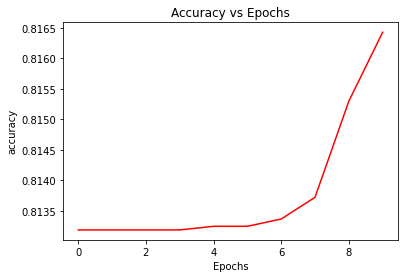

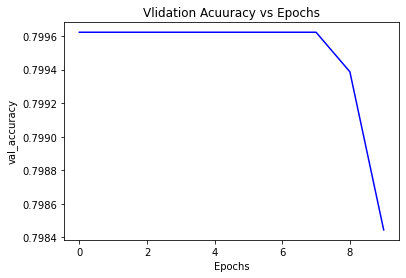

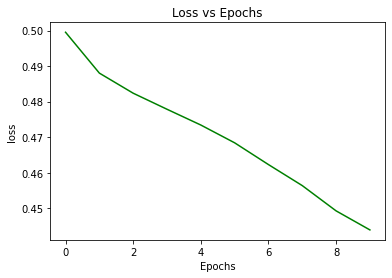

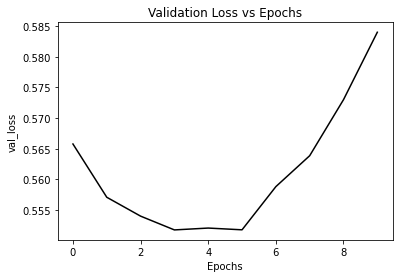

In [ ]:
coronal_abnormal = MRNet.fit(coronal_abnormal, epochs = 10,steps_per_epoch= coronalt_length,validation_data= coronal_abnormal_val,validation_steps=coronalv_length )
abnormalAccuracys.append(Average(coronal_abnormal.history['val_accuracy']))
plot_graphs(coronal_abnormal)

In [ ]:
sagittal_abnormal = MRNet.fit(sagittal_abnormal, epochs = 5,steps_per_epoch= saggitalt_length,validation_data= sagittal_abnormal_val,validation_steps=saggitalv_length )
abnormalAccuracys.append(Average(sagittal_abnormal.history['val_accuracy']))
#plot_graphs(sagittal_abnormal)

Epoch 1/5
1130/1130 [==============================] - 877s 777ms/step - loss: 0.5068 - accuracy: 0.8094 - val_loss: 0.5140 - val_accuracy: 0.7908
Epoch 2/5
1130/1130 [==============================] - 60s 53ms/step - loss: 0.4915 - accuracy: 0.8100 - val_loss: 0.5152 - val_accuracy: 0.7908
Epoch 3/5
1130/1130 [==============================] - 51s 45ms/step - loss: 0.4842 - accuracy: 0.8100 - val_loss: 0.5161 - val_accuracy: 0.7908
Epoch 4/5
1130/1130 [==============================] - 51s 45ms/step - loss: 0.4779 - accuracy: 0.8100 - val_loss: 0.5166 - val_accuracy: 0.7908
Epoch 5/5
1130/1130 [==============================] - 53s 47ms/step - loss: 0.4714 - accuracy: 0.8100 - val_loss: 0.5190 - val_accuracy: 0.7908


In [ ]:
aclAccuracys=[]
axial_acl = MRNet.fit(axial_acl, epochs = 5,steps_per_epoch= axialt_length,validation_data= axial_acl_val,validation_steps=axialv_length)
aclAccuracys.append(Average(axial_acl.history['val_accuracy'])) 
#plot_graphs(axial_acl)

Epoch 1/5
1130/1130 [==============================] - 490s 434ms/step - loss: 0.5336 - accuracy: 0.8004 - val_loss: 0.9011 - val_accuracy: 0.5591
Epoch 2/5
1130/1130 [==============================] - 65s 58ms/step - loss: 0.5013 - accuracy: 0.8140 - val_loss: 0.8849 - val_accuracy: 0.5591
Epoch 3/5
1130/1130 [==============================] - 57s 50ms/step - loss: 0.4913 - accuracy: 0.8141 - val_loss: 0.8900 - val_accuracy: 0.5591
Epoch 4/5
1130/1130 [==============================] - 58s 51ms/step - loss: 0.4833 - accuracy: 0.8141 - val_loss: 0.8981 - val_accuracy: 0.5591
Epoch 5/5
1130/1130 [==============================] - 58s 51ms/step - loss: 0.4756 - accuracy: 0.8139 - val_loss: 0.9052 - val_accuracy: 0.5591


In [ ]:
coronal_acl = MRNet.fit(coronal_acl, epochs = 5,steps_per_epoch= coronalt_length,validation_data= coronal_acl_val,validation_steps=coronalv_length )
abnormalAccuracys.append(Average(coronal_acl.history['val_accuracy']))
#plot_graphs(coronal_acl)

Epoch 1/5
1130/1130 [==============================] - 518s 458ms/step - loss: 0.5100 - accuracy: 0.8080 - val_loss: 0.8636 - val_accuracy: 0.5448
Epoch 2/5
1130/1130 [==============================] - 66s 59ms/step - loss: 0.4964 - accuracy: 0.8084 - val_loss: 0.8889 - val_accuracy: 0.5448
Epoch 3/5
1130/1130 [==============================] - 51s 45ms/step - loss: 0.4891 - accuracy: 0.8084 - val_loss: 0.9042 - val_accuracy: 0.5448
Epoch 4/5
1130/1130 [==============================] - 52s 46ms/step - loss: 0.4824 - accuracy: 0.8084 - val_loss: 0.9267 - val_accuracy: 0.5448
Epoch 5/5
1130/1130 [==============================] - 50s 44ms/step - loss: 0.4756 - accuracy: 0.8084 - val_loss: 0.9419 - val_accuracy: 0.5448


In [ ]:
sagittal_acl = MRNet.fit(sagittal_acl, epochs = 5,steps_per_epoch= saggitalt_length,validation_data= sagittal_acl_val,validation_steps=saggitalv_length )
abnormalAccuracys.append(Average(sagittal_acl.history['val_accuracy']))
#plot_graphs(sagittal_acl)

Epoch 1/5
1130/1130 [==============================] - 530s 469ms/step - loss: 0.4955 - accuracy: 0.8181 - val_loss: 0.9857 - val_accuracy: 0.5546
Epoch 2/5
1130/1130 [==============================] - 68s 60ms/step - loss: 0.4808 - accuracy: 0.8181 - val_loss: 1.0377 - val_accuracy: 0.5546
Epoch 3/5
1130/1130 [==============================] - 63s 56ms/step - loss: 0.4726 - accuracy: 0.8178 - val_loss: 1.0815 - val_accuracy: 0.5546
Epoch 4/5
1130/1130 [==============================] - 51s 45ms/step - loss: 0.4647 - accuracy: 0.8177 - val_loss: 1.1215 - val_accuracy: 0.5546
Epoch 5/5
1130/1130 [==============================] - 51s 45ms/step - loss: 0.4567 - accuracy: 0.8177 - val_loss: 1.1486 - val_accuracy: 0.5546


In [ ]:
meniscusAccuracys=[]
axial_meniscus = MRNet.fit(axial_meniscus, epochs = 5,steps_per_epoch= axialt_length,validation_data= axial_meniscus_val,validation_steps=axialv_length)
meniscusAccuracys.append(Average(axial_meniscus.history['val_accuracy'])) 
#plot_graphs(axial_meniscus)

Epoch 1/5
1130/1130 [==============================] - 503s 446ms/step - loss: 0.6629 - accuracy: 0.6429 - val_loss: 0.6947 - val_accuracy: 0.5863
Epoch 2/5
1130/1130 [==============================] - 72s 63ms/step - loss: 0.6499 - accuracy: 0.6442 - val_loss: 0.6988 - val_accuracy: 0.5858
Epoch 3/5
1130/1130 [==============================] - 70s 62ms/step - loss: 0.6425 - accuracy: 0.6452 - val_loss: 0.7058 - val_accuracy: 0.5838
Epoch 4/5
1130/1130 [==============================] - 64s 57ms/step - loss: 0.6347 - accuracy: 0.6458 - val_loss: 0.7145 - val_accuracy: 0.5829
Epoch 5/5
1130/1130 [==============================] - 57s 51ms/step - loss: 0.6257 - accuracy: 0.6496 - val_loss: 0.7291 - val_accuracy: 0.5826


In [ ]:
coronal_meniscus = MRNet.fit(coronal_meniscus, epochs = 5,steps_per_epoch= axialt_length,validation_data= coronal_meniscus_val,validation_steps=coronalv_length)
meniscusAccuracys.append(Average(coronal_meniscus.history['val_accuracy'])) 
#plot_graphs(coronal_meniscus)

Epoch 1/5
1130/1130 [==============================] - 546s 484ms/step - loss: 0.6585 - accuracy: 0.6398 - val_loss: 0.7086 - val_accuracy: 0.5712
Epoch 2/5
1130/1130 [==============================] - 68s 60ms/step - loss: 0.6445 - accuracy: 0.6447 - val_loss: 0.7175 - val_accuracy: 0.5712
Epoch 3/5
1130/1130 [==============================] - 67s 60ms/step - loss: 0.6357 - accuracy: 0.6478 - val_loss: 0.7286 - val_accuracy: 0.5712
Epoch 4/5
1130/1130 [==============================] - 65s 58ms/step - loss: 0.6271 - accuracy: 0.6535 - val_loss: 0.7374 - val_accuracy: 0.5714
Epoch 5/5
1130/1130 [==============================] - 52s 46ms/step - loss: 0.6173 - accuracy: 0.6598 - val_loss: 0.7538 - val_accuracy: 0.5705


In [ ]:
sagittal_meniscus = MRNet.fit(sagittal_meniscus, epochs = 5,steps_per_epoch= axialt_length,validation_data= sagittal_meniscus_val,validation_steps=saggitalv_length)
meniscusAccuracys.append(Average(sagittal_meniscus.history['val_accuracy'])) 
#plot_graphs(sagittal_meniscus)

Epoch 1/5
1130/1130 [==============================] - 597s 529ms/step - loss: 0.6628 - accuracy: 0.6410 - val_loss: 0.7078 - val_accuracy: 0.5712
Epoch 2/5
1130/1130 [==============================] - 68s 60ms/step - loss: 0.6488 - accuracy: 0.6443 - val_loss: 0.7117 - val_accuracy: 0.5700
Epoch 3/5
1130/1130 [==============================] - 67s 59ms/step - loss: 0.6399 - accuracy: 0.6461 - val_loss: 0.7160 - val_accuracy: 0.5693
Epoch 4/5
1130/1130 [==============================] - 67s 59ms/step - loss: 0.6305 - accuracy: 0.6497 - val_loss: 0.7234 - val_accuracy: 0.5620
Epoch 5/5
1130/1130 [==============================] - 66s 58ms/step - loss: 0.6201 - accuracy: 0.6567 - val_loss: 0.7333 - val_accuracy: 0.5517


In [ ]:
print(len(abnormalAccuracys))
print(len(meniscusAccuracys))
print(len(aclAccuracys))

5
3
1


In [ ]:
# For built-In Models
print("Accuracy Abnormal = ",Average(abnormalAccuracys)*100,"%")
print("Accuracy Meniscus = ",Average(meniscusAccuracys)*100,"%")
print("Accuracy Acl = ",Average(aclAccuracys)*100,"%")

Accuracy Abnormal =  69.67709302902222 %
Accuracy Meniscus =  57.340435981750495 %
Accuracy Acl =  55.90875744819641 %


In [ ]:
#predict if the knee has an acl tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an abnromal tear or not
#by doing a majority voting between the 3 models
def predict_abnormal(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_abnormal_prediction = axial_abnormal.predict(axial_input)
    coronal_abnormal_prediction = coronal_abnormal.predict(coronal_input)
    sagittal_abnormal_prediction = sagittal_abnormal.predict(sagittal_input)
    
    #to say that the exam has the acl tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_abnormal_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_acl_model vote for the final decision 
        if(axial_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_acl_model vote for the final decision 
        if(coronal_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_acl_model vote for the final decision 
        if(sagittal_abnormal_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [ ]:
#predict if the knee has an acl tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an acl tear or not
#by doing a majority voting between the 3 models
def predict_acl(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_acl_prediction = axial_acl.predict(axial_input)
    coronal_acl_prediction = coronal_acl.predict(coronal_input)
    sagittal_acl_prediction = sagittal_acl.predict(sagittal_input)
    
    #to say that the exam has the acl tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_acl_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_acl_model vote for the final decision 
        if(axial_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_acl_model vote for the final decision 
        if(coronal_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_acl_model vote for the final decision 
        if(sagittal_acl_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100


In [ ]:
#predict if the knee has an meniscus tear by using the data of the 3 knee angel (axial, coronal & sagittal)
#and the 3 models that accept one of these data and predict if the knee has an meniscus tear or not
#by doing a majority voting between the 3 models
def predict_meniscus(axial_input, coronal_input, sagittal_input, ground_truth):
    axial_meniscus_prediction = axial_meniscus.predict(axial_input)
    coronal_meniscus_prediction = coronal_meniscus.predict(coronal_input)
    sagittal_meniscus_prediction = sagittal_meniscus.predict(sagittal_input)
    
    #to say that the exam has the meniscus tear or not, each of the models will vote in this decision
    #and the final decision will be made by taking the max vote
    predict_voting = []
    for i in range (len(axial_meniscus_prediction)):
        voting_list =[0, 0] 
        
        #make the axial_meniscus_model vote for the final decision 
        if(axial_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
    
        #make the coronal_meniscus_model vote for the final decision 
        if(coronal_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
            
        #make the sagittal_meniscus_model vote for the final decision 
        if(sagittal_meniscus_prediction[i]>0.5):
            voting_list[1] +=1
        else:
            voting_list[0] += 1
        
        #give the exam the prediction that has the most votes
        predict_voting.append(np.argmax(voting_list))
    
  
    return accuracy_score(ground_truth, np.array(predict_voting)) * 100

In [ ]:
# For Modified Models.
#evaluate the abnormal ensemble models
print (predict_abnormal(test_set_axial, test_set_coronal, test_set_sagittal, test_label_abnormal))

NameError: ignored

In [ ]:
 For Modified Models.
#evaluate the acl ensemble models
print (predict_acl(test_set_axial, test_set_coronal, test_set_sagittal, test_label_acl))

In [ ]:
# For Modified Models.
#evaluate the meniscus ensemble models
print (predict_meniscus(test_set_axial, test_set_coronal, test_set_sagittal, test_label_meniscus))


In [ ]:
MRNet.save('/content/drive/MyDrive/MRNET/MRNet-v1.0/MR_Alexnet_model.h5')